## Bike sharing Assignment

###### Build a multiple linear regression model for the prediction of demand for shared bikes

\-To identify variable s affecting bike sharing 

\-To build linear model which can relate no of bike sharing with other variables like da , year, weather  etc

\-To know the accuracy of the model

\-To evaluate the model



### 1.Prepare data



#### Import required libraries



In [60]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [61]:
bike_sharing_dataset = pd.read_csv('day.csv')
bike_sharing_dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [62]:
bike_sharing_dataset.shape

(730, 16)

In [63]:
bike_sharing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [64]:
#checking if any columns with only one value
bike_sharing_dataset.nunique().sort_values()

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
casual        605
windspeed     649
registered    678
atemp         689
cnt           695
instant       730
dteday        730
dtype: int64

In [65]:
#checking what values present, it has only 3 values instead of 4 values
bike_sharing_dataset['weathersit'].value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

### 2.Cleaning the data

Removing the below columns which does not add any value to building model

\-instant:not required as it is record index no

\-dteday: not required as it is already part of  yr, mnth,weekday

\-temp: represented by 'atemp', 'atemp' is human feeling of temperature, which can influence person to take bike or not, which can give better understanding

\-hum: represented by atemp indirectly, humidity is inversely proportional to temp so not required to have this variable

\-casual, registered: these are subset of target variable 'cnt' , not required for finding linear model



In [66]:
not_required_columns =['instant','dteday','temp','hum','casual','registered']
bike_sharing_dataset = bike_sharing_dataset.drop(not_required_columns,axis=1)
bike_sharing_dataset.shape

(730, 10)

In [67]:
bike_sharing_dataset.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,windspeed,cnt
0,1,0,1,0,6,0,2,18.18125,10.749882,985
1,1,0,1,0,0,0,2,17.68695,16.652113,801
2,1,0,1,0,1,1,1,9.47025,16.636703,1349
3,1,0,1,0,2,1,1,10.60610,10.739832,1562
4,1,0,1,0,3,1,1,11.46350,12.522300,1600


#### 3.Visualise data

\-Understand data

\-Check any variable strongly related with target variable


##### Visualising Numeric  variable



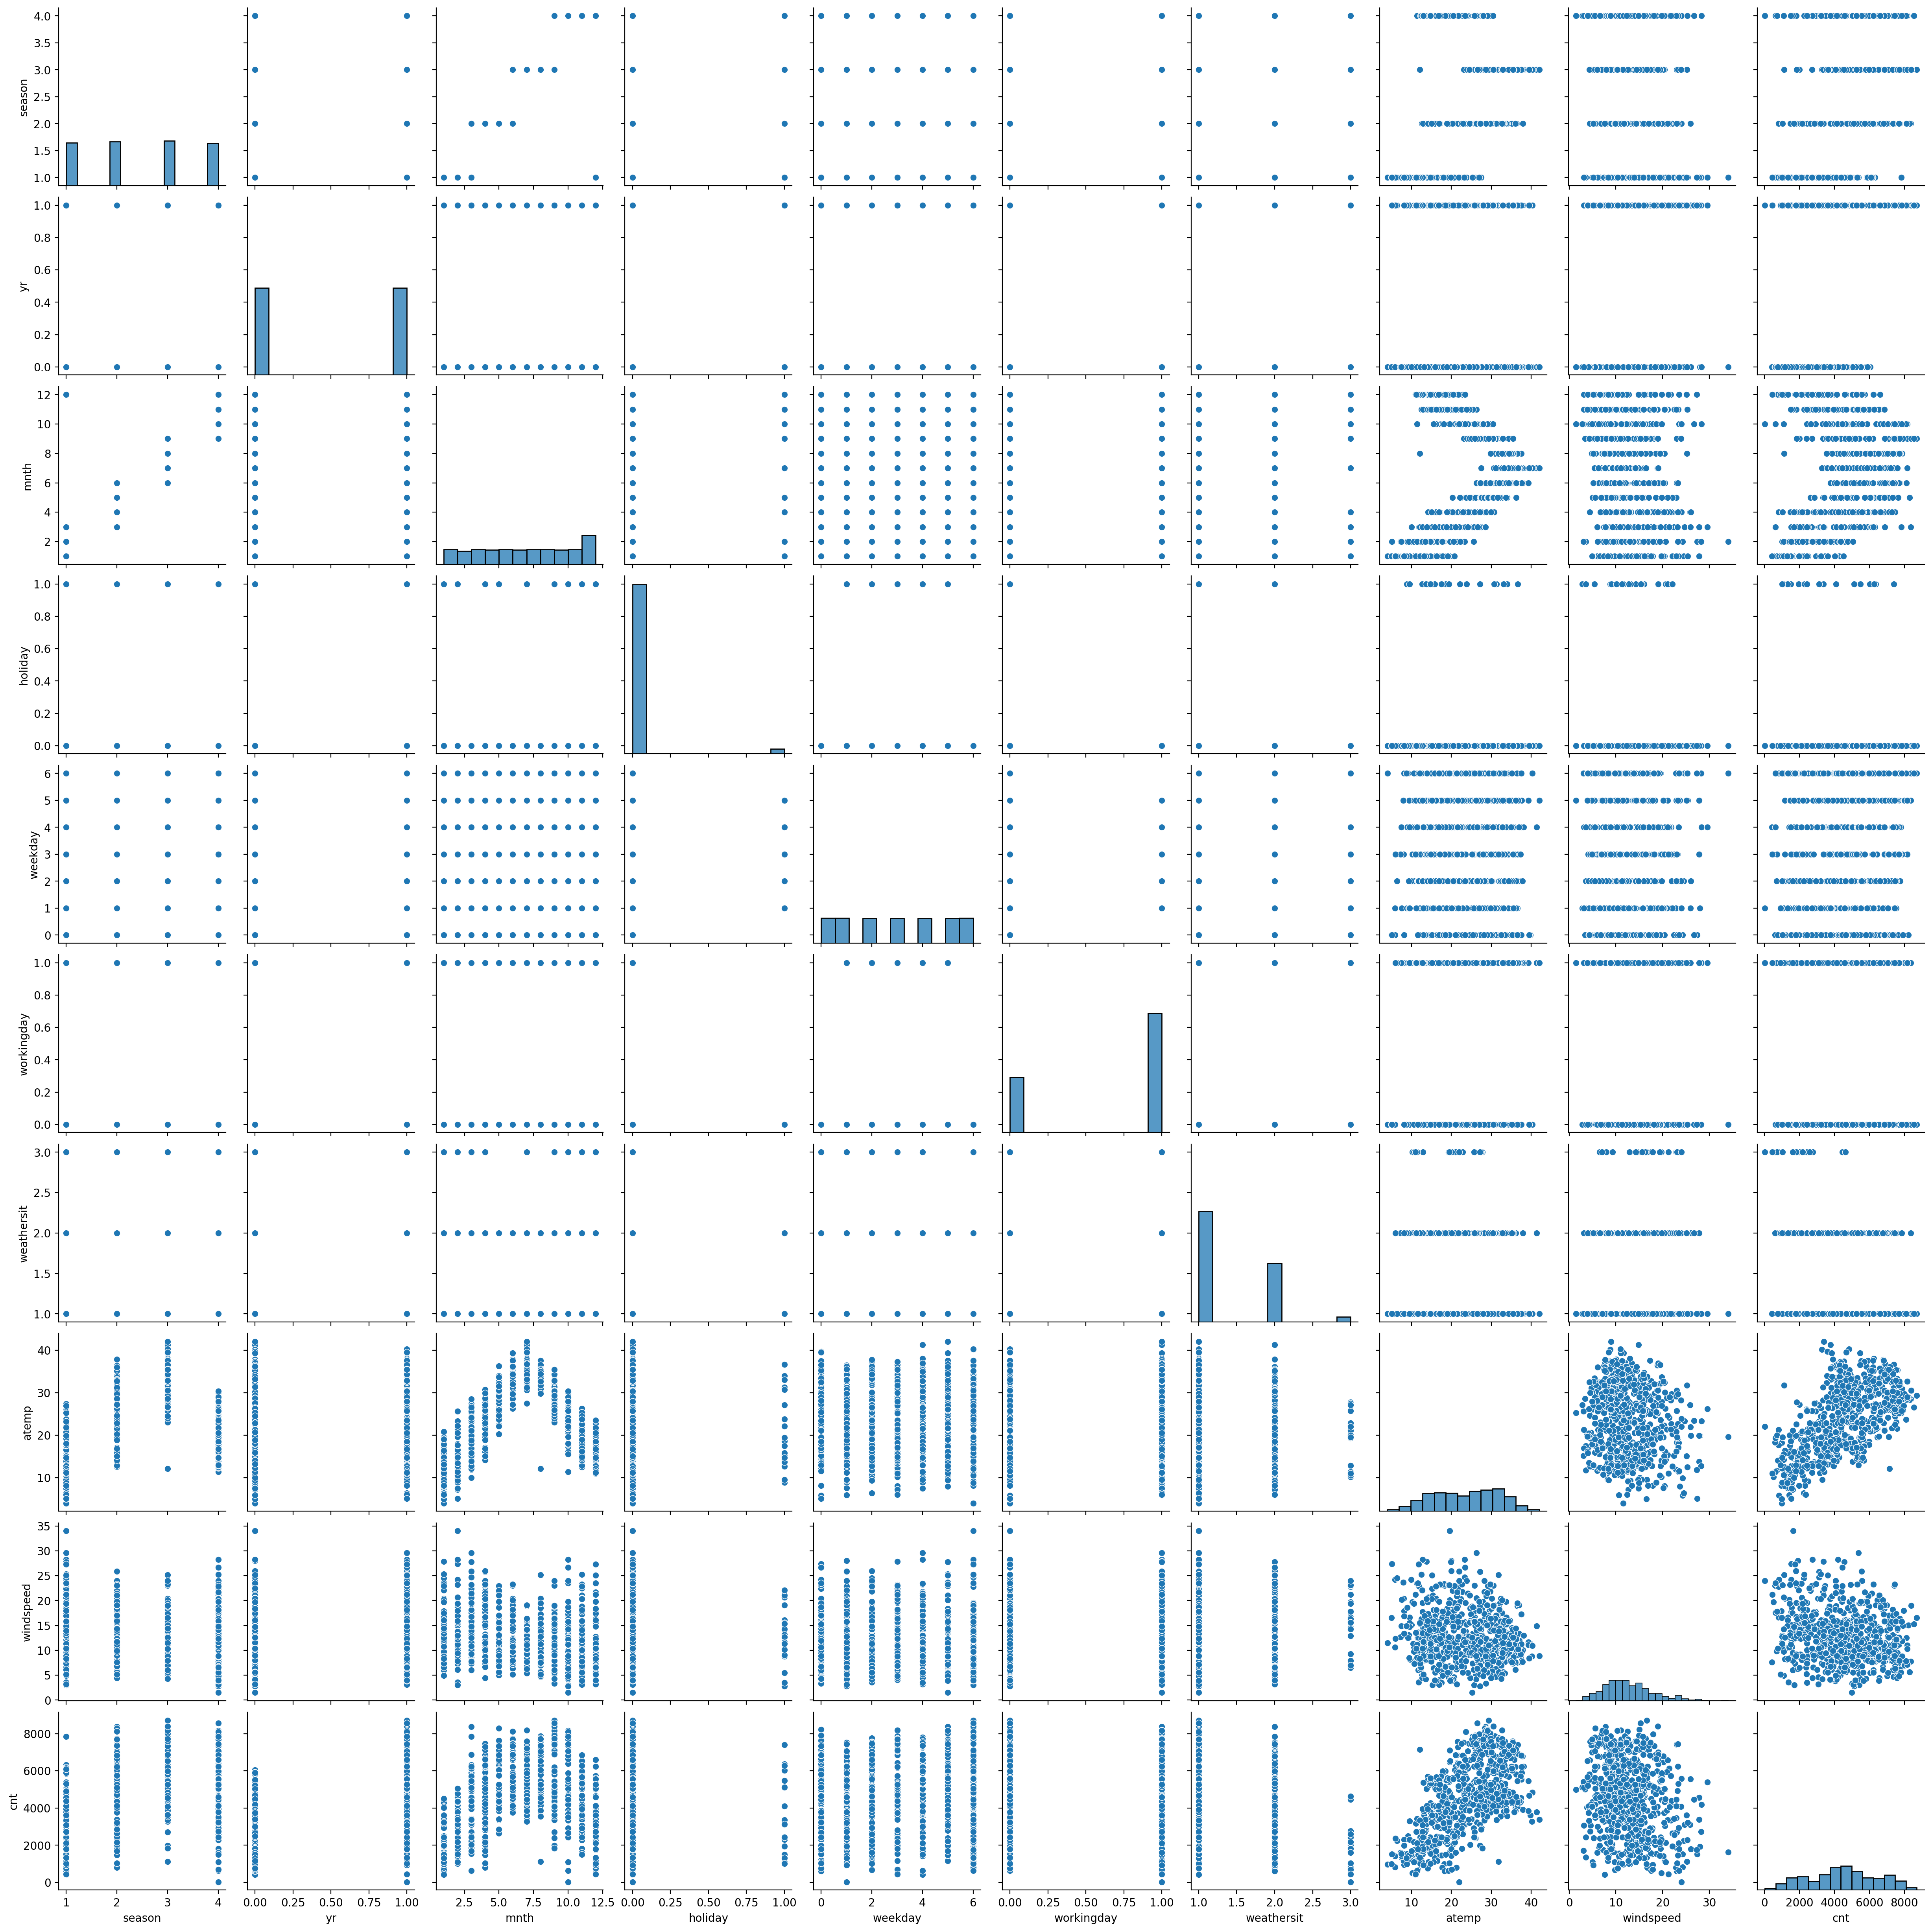

In [68]:
sns.pairplot(bike_sharing_dataset)

##### Visualising Categoric variable

we can observe 'weathersit' and 'season' is categorical variable



##### Lets convert these variables levels into string based categorical variable for further analysis



weathersit : 

\- 1: Clear, Few clouds, Partly cloudy, Partly cloudy

\- 2: Mist \+ Cloudy, Mist \+ Broken clouds, Mist \+ Few clouds, Mist

\- 3: Light Snow, Light Rain \+ Thunderstorm \+ Scattered clouds, Light Rain \+ Scattered clouds

\- 4: Heavy Rain \+ Ice Pallets \+ Thunderstorm \+ Mist, Snow \+ Fog



In [69]:
def weathersit_decode(x):
    switcher={
        1:"Clear",
        2:"Mist",
        3:"LightSnow",
        4:"HeavyRain"
    }
    return switcher.get(x)

bike_sharing_dataset['weathersit']=bike_sharing_dataset['weathersit'].apply(weathersit_decode)
bike_sharing_dataset['weathersit'].value_counts()

Clear        463
Mist         246
LightSnow     21
Name: weathersit, dtype: int64

season : 

\-1:spring

\-2:summer

\-3:fall

\-4:winter



In [70]:
def season_decode(x):
    switcher={
        1:"spring",
        2:"summer",
        3:"fall",
        4:"winter"
    }
    return switcher.get(x)

bike_sharing_dataset['season']=bike_sharing_dataset['season'].apply(season_decode)
bike_sharing_dataset['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

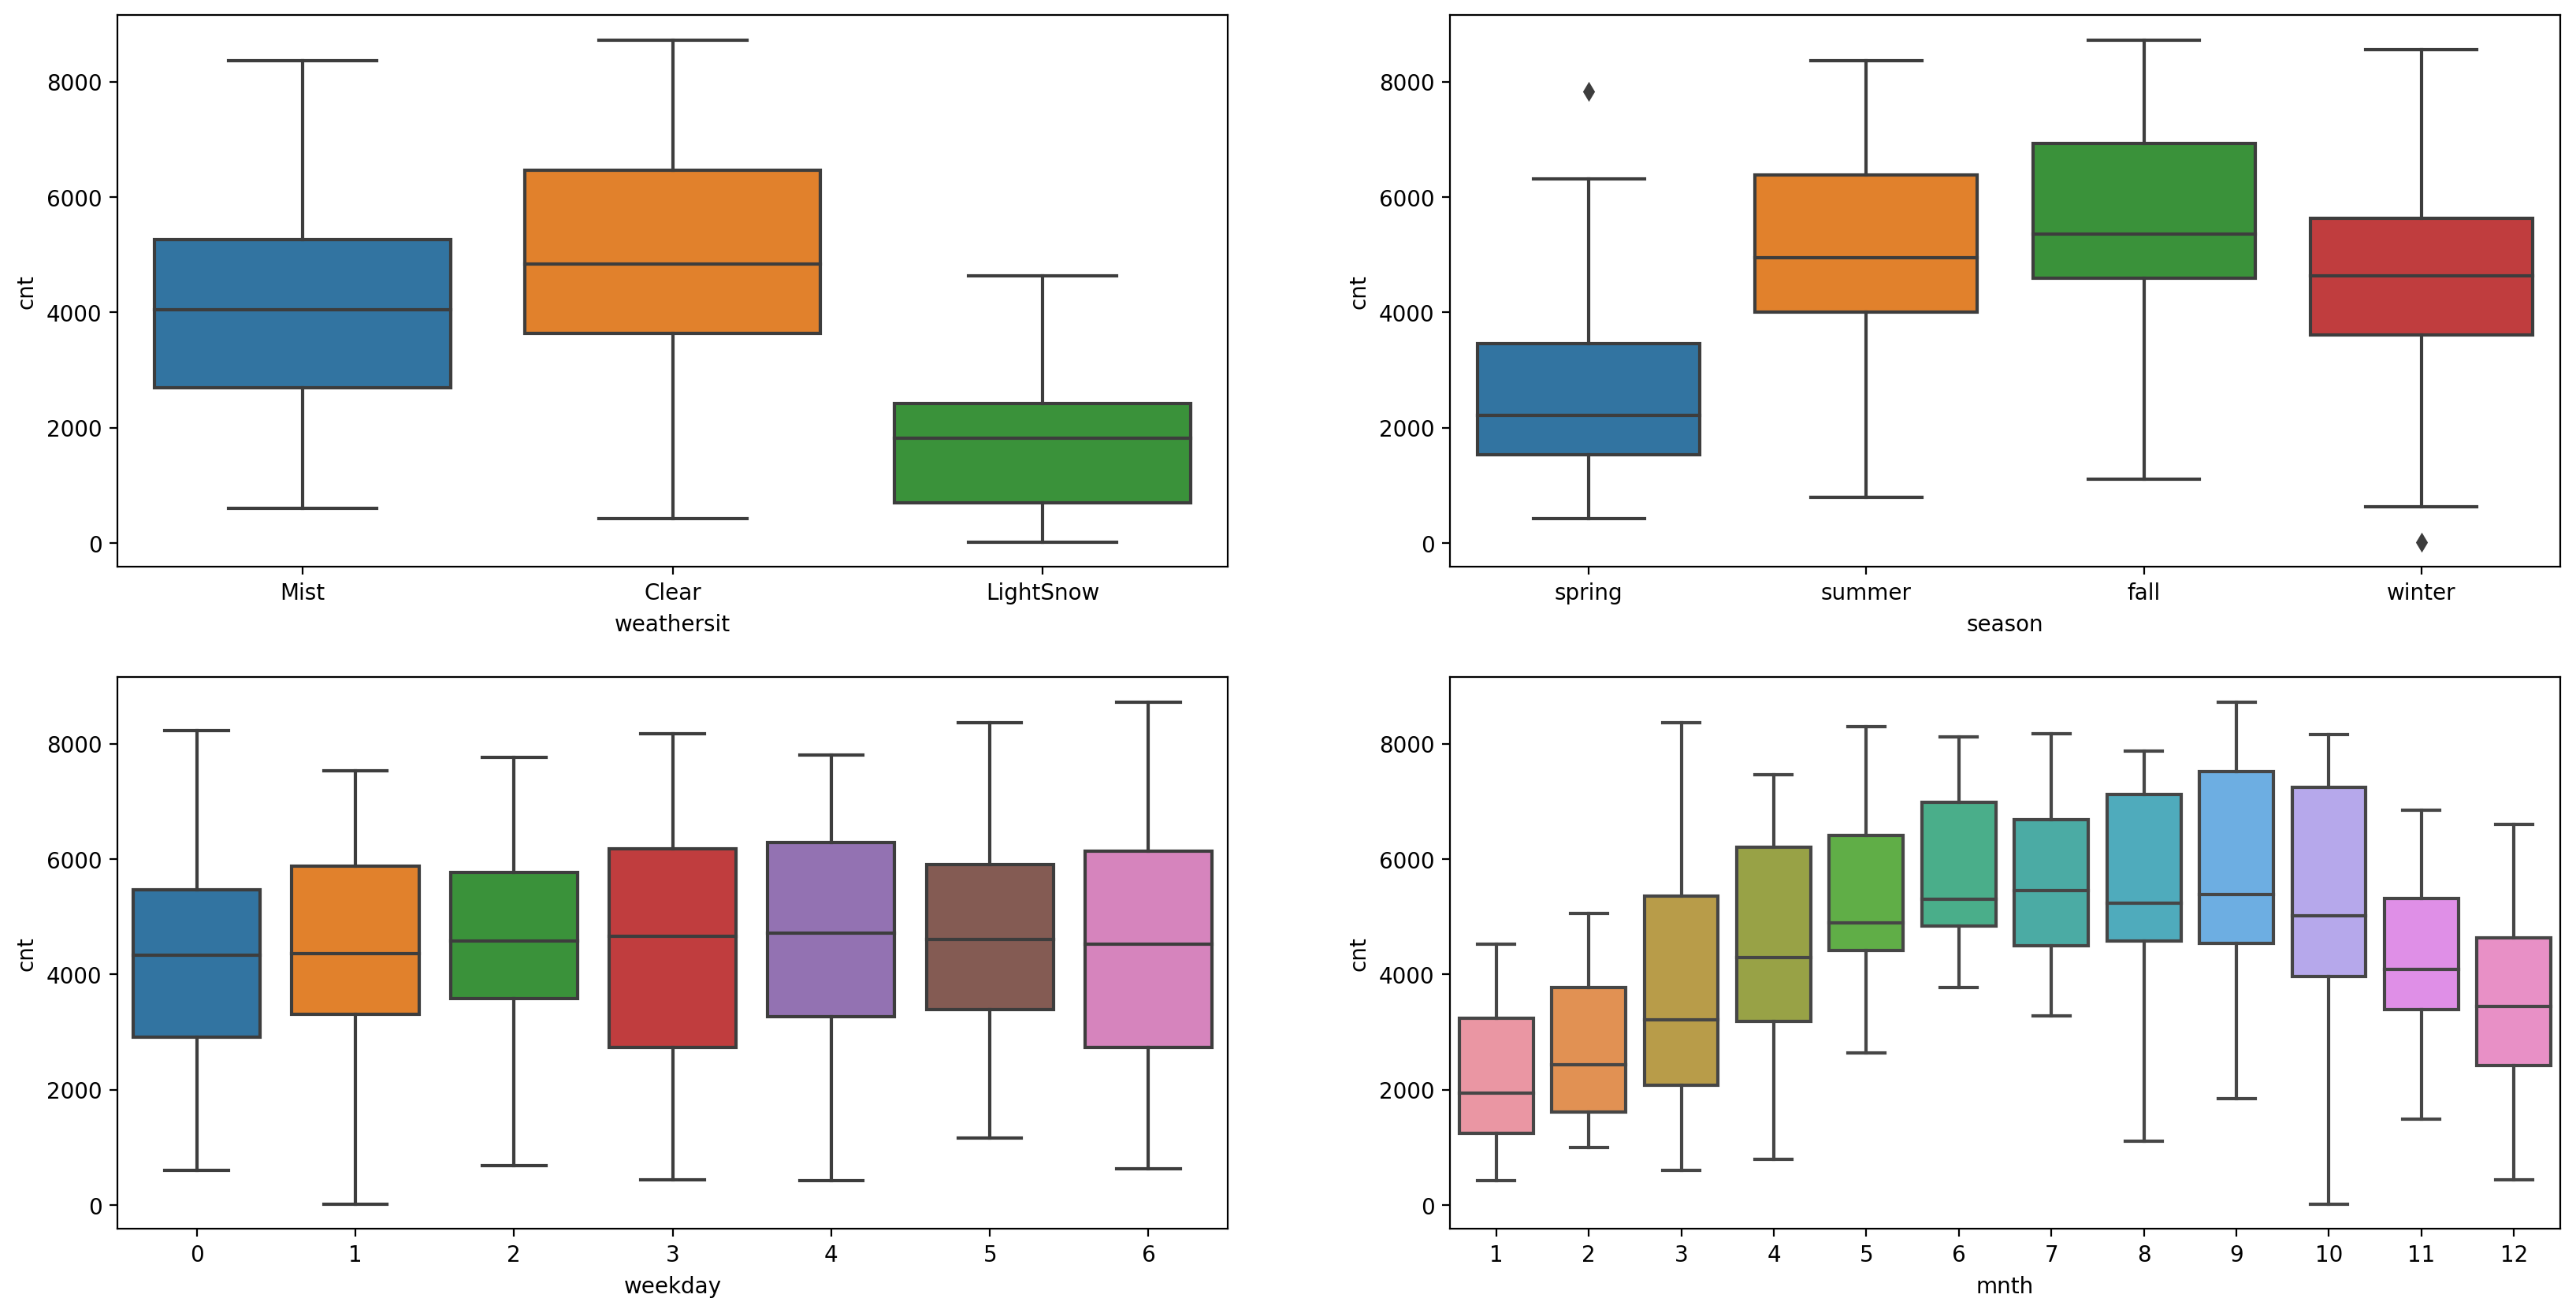

In [71]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
sns.boxplot(x='weathersit', y='cnt',data=bike_sharing_dataset )
plt.subplot(2,2,2)
sns.boxplot(x='season', y='cnt',data=bike_sharing_dataset )
plt.subplot(2,2,3)
sns.boxplot(x='weekday', y='cnt',data=bike_sharing_dataset )
plt.subplot(2,2,4)
sns.boxplot(x='mnth', y='cnt',data=bike_sharing_dataset )
plt.show()

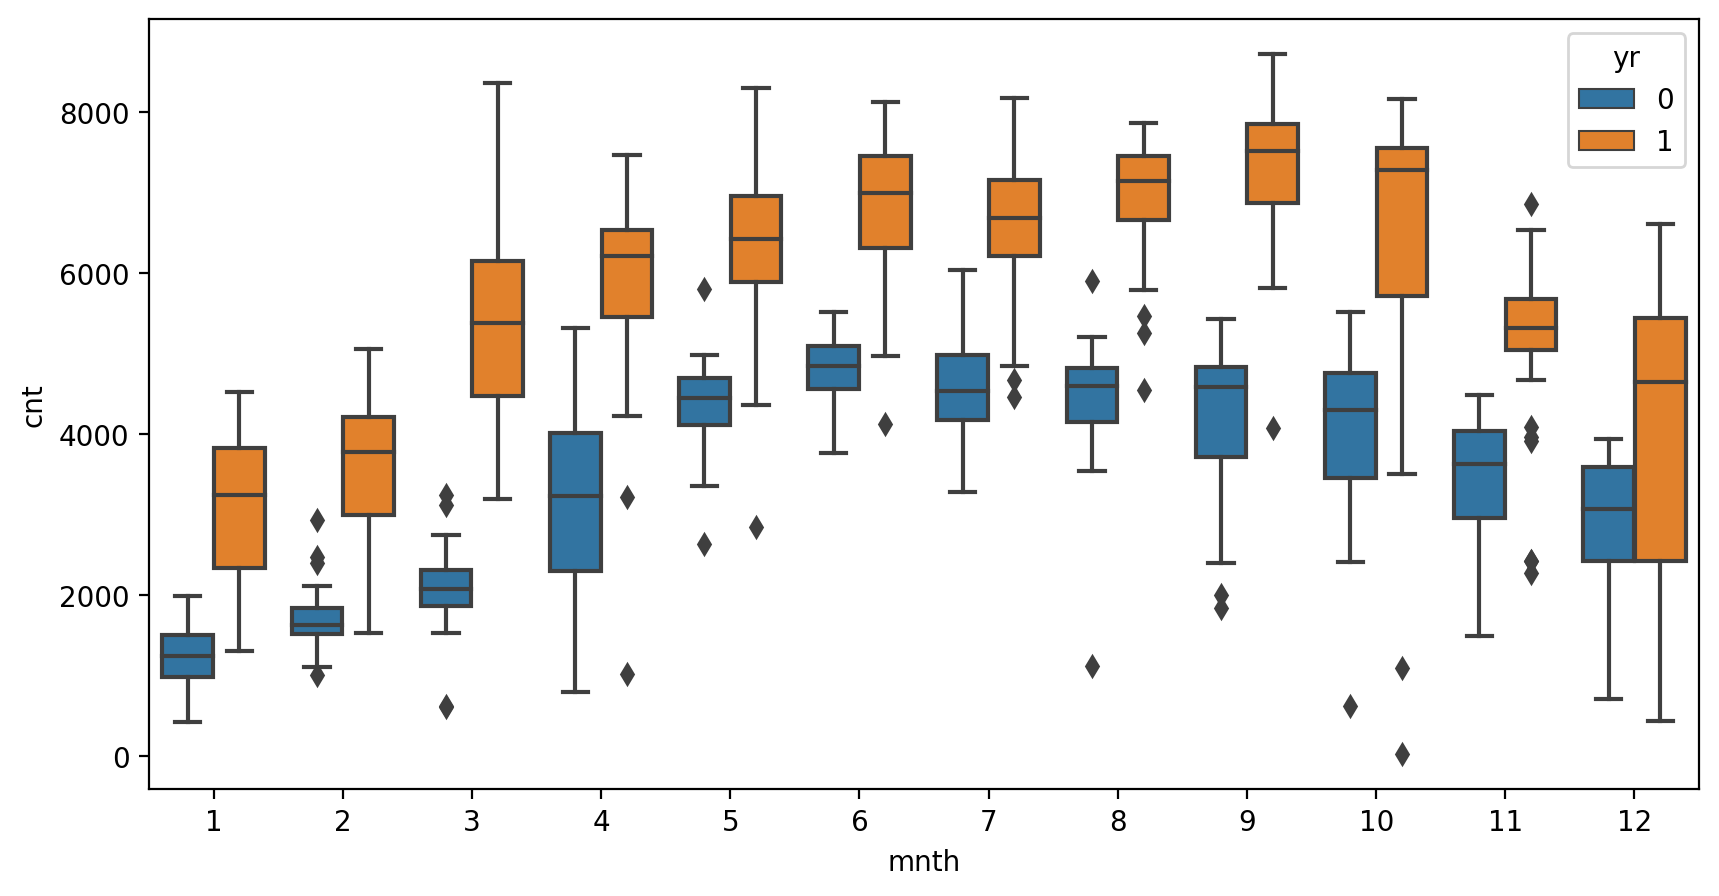

In [72]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'mnth', y = 'cnt', hue = 'yr', data = bike_sharing_dataset)
plt.show()

### 4.Data Preparation

We can observe there are variables '

\-weathersit' and 'season' with multiple levels, these level doesn't have any order , we should create dummy variables for these

\-'weekday' column has mean value around same range not adding much value for analysis, is indirectly represented by 'holiday' and 'workingday' column so dropping it

\-'mnth' column is showing  pattern of bike usage based on months so keeping it



#### Dummy Variables

lets create dummy variables for 'weathersit' and 'season'



In [73]:
 weathersit_dummy=pd.get_dummies(bike_sharing_dataset['weathersit'])

In [74]:
weathersit_dummy.head()

,Clear,LightSnow,Mist
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,1,0,0


Only two columns required , lets get 2 level dummy columns, by dropping first column

00  \-clear

01 \- mist

10 \- Light snow



In [75]:
 weathersit_dummy=pd.get_dummies(bike_sharing_dataset['weathersit'], drop_first =True)

In [76]:
#add result to dataset
bike_sharing_dataset=pd.concat([bike_sharing_dataset,weathersit_dummy],axis =1)

In [77]:
#lets see the dataset as a whole
bike_sharing_dataset.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,windspeed,cnt,LightSnow,Mist
0,spring,0,1,0,6,0,Mist,18.18125,10.749882,985,0,1
1,spring,0,1,0,0,0,Mist,17.68695,16.652113,801,0,1
2,spring,0,1,0,1,1,Clear,9.47025,16.636703,1349,0,0
3,spring,0,1,0,2,1,Clear,10.60610,10.739832,1562,0,0
4,spring,0,1,0,3,1,Clear,11.46350,12.522300,1600,0,0


In [78]:
#drop weather sit as we have created dummy variables
bike_sharing_dataset.drop(['weathersit'],axis=1, inplace=True)

In [79]:
bike_sharing_dataset.head()

,season,yr,mnth,holiday,weekday,workingday,atemp,windspeed,cnt,LightSnow,Mist
0,spring,0,1,0,6,0,18.18125,10.749882,985,0,1
1,spring,0,1,0,0,0,17.68695,16.652113,801,0,1
2,spring,0,1,0,1,1,9.47025,16.636703,1349,0,0
3,spring,0,1,0,2,1,10.60610,10.739832,1562,0,0
4,spring,0,1,0,3,1,11.46350,12.522300,1600,0,0


In [80]:
#creation of dummy variables for season
season_dummy=pd.get_dummies(bike_sharing_dataset['season'])
season_dummy.head()

,fall,spring,summer,winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [81]:
# considering fall-000, spring-100, simmer-010, winter-001 we can drop fall column
season_dummy=pd.get_dummies(bike_sharing_dataset['season'], drop_first=True)
#add the coulmns to original dataset
bike_sharing_dataset = pd.concat([bike_sharing_dataset,season_dummy],axis=1)
#season column is not required as represented by respective dummy columns
bike_sharing_dataset.drop(['season'],axis=1,inplace=True)

In [82]:
bike_sharing_dataset.head()

,yr,mnth,holiday,weekday,workingday,atemp,windspeed,cnt,LightSnow,Mist,spring,summer,winter
0,0,1,0,6,0,18.18125,10.749882,985,0,1,1,0,0
1,0,1,0,0,0,17.68695,16.652113,801,0,1,1,0,0
2,0,1,0,1,1,9.47025,16.636703,1349,0,0,1,0,0
3,0,1,0,2,1,10.60610,10.739832,1562,0,0,1,0,0
4,0,1,0,3,1,11.46350,12.522300,1600,0,0,1,0,0


In [83]:
#droping column weekday
bike_sharing_dataset.drop(['weekday'],axis=1,inplace=True)

### 5.Splitting the Data into Training and Testing Sets



In [84]:
#to get train and test data set always same rows, respectively
import numpy as np
np.random.seed(0)
data_train,data_test=train_test_split(bike_sharing_dataset, train_size = 0.7, test_size = 0.3, random_state = 100)

##### Scaling

<span style='font-size:small'>If we observe columns ,there are columns with big numbers . To have all columns in comparable scale lets do scaling by using min\-max scaler</span>



In [85]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [86]:
bike_sharing_dataset.columns

Index(['yr', 'mnth', 'holiday', 'workingday', 'atemp', 'windspeed', 'cnt',
       'LightSnow', 'Mist', 'spring', 'summer', 'winter'],
      dtype='object')

In [87]:
#Apply scaler() to all the columns except 'dummy' variables
scaler_columns = ['yr', 'mnth', 'atemp', 'windspeed', 'cnt']

In [88]:
data_train[scaler_columns] = scaler.fit_transform(data_train[scaler_columns])
data_train.head()

,yr,mnth,holiday,workingday,atemp,windspeed,cnt,LightSnow,Mist,spring,summer,winter
653,1.0,0.818182,0,1,0.501133,0.300794,0.864243,0,0,0,0,1
576,1.0,0.545455,0,1,0.766351,0.264686,0.827658,0,0,0,0,0
426,1.0,0.181818,0,0,0.438975,0.255342,0.465255,0,1,1,0,0
728,1.0,1.000000,0,0,0.200348,0.663106,0.204096,0,0,1,0,0
482,1.0,0.272727,0,0,0.391735,0.188475,0.482973,0,1,0,1,0


In [89]:
data_train.describe()

,yr,mnth,holiday,workingday,atemp,windspeed,cnt,LightSnow,Mist,spring,summer,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000
mean,0.507843,0.504456,0.025490,0.676471,0.512989,0.320768,0.513620,0.029412,0.343137,0.243137,0.245098,0.24902
std,0.500429,0.315338,0.157763,0.468282,0.212385,0.169797,0.224593,0.169124,0.475223,0.429398,0.430568,0.43287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.181818,0.000000,0.000000,0.332086,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,0.545455,0.000000,1.000000,0.526811,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,0.818182,0.000000,1.000000,0.688457,0.414447,0.684710,0.000000,1.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


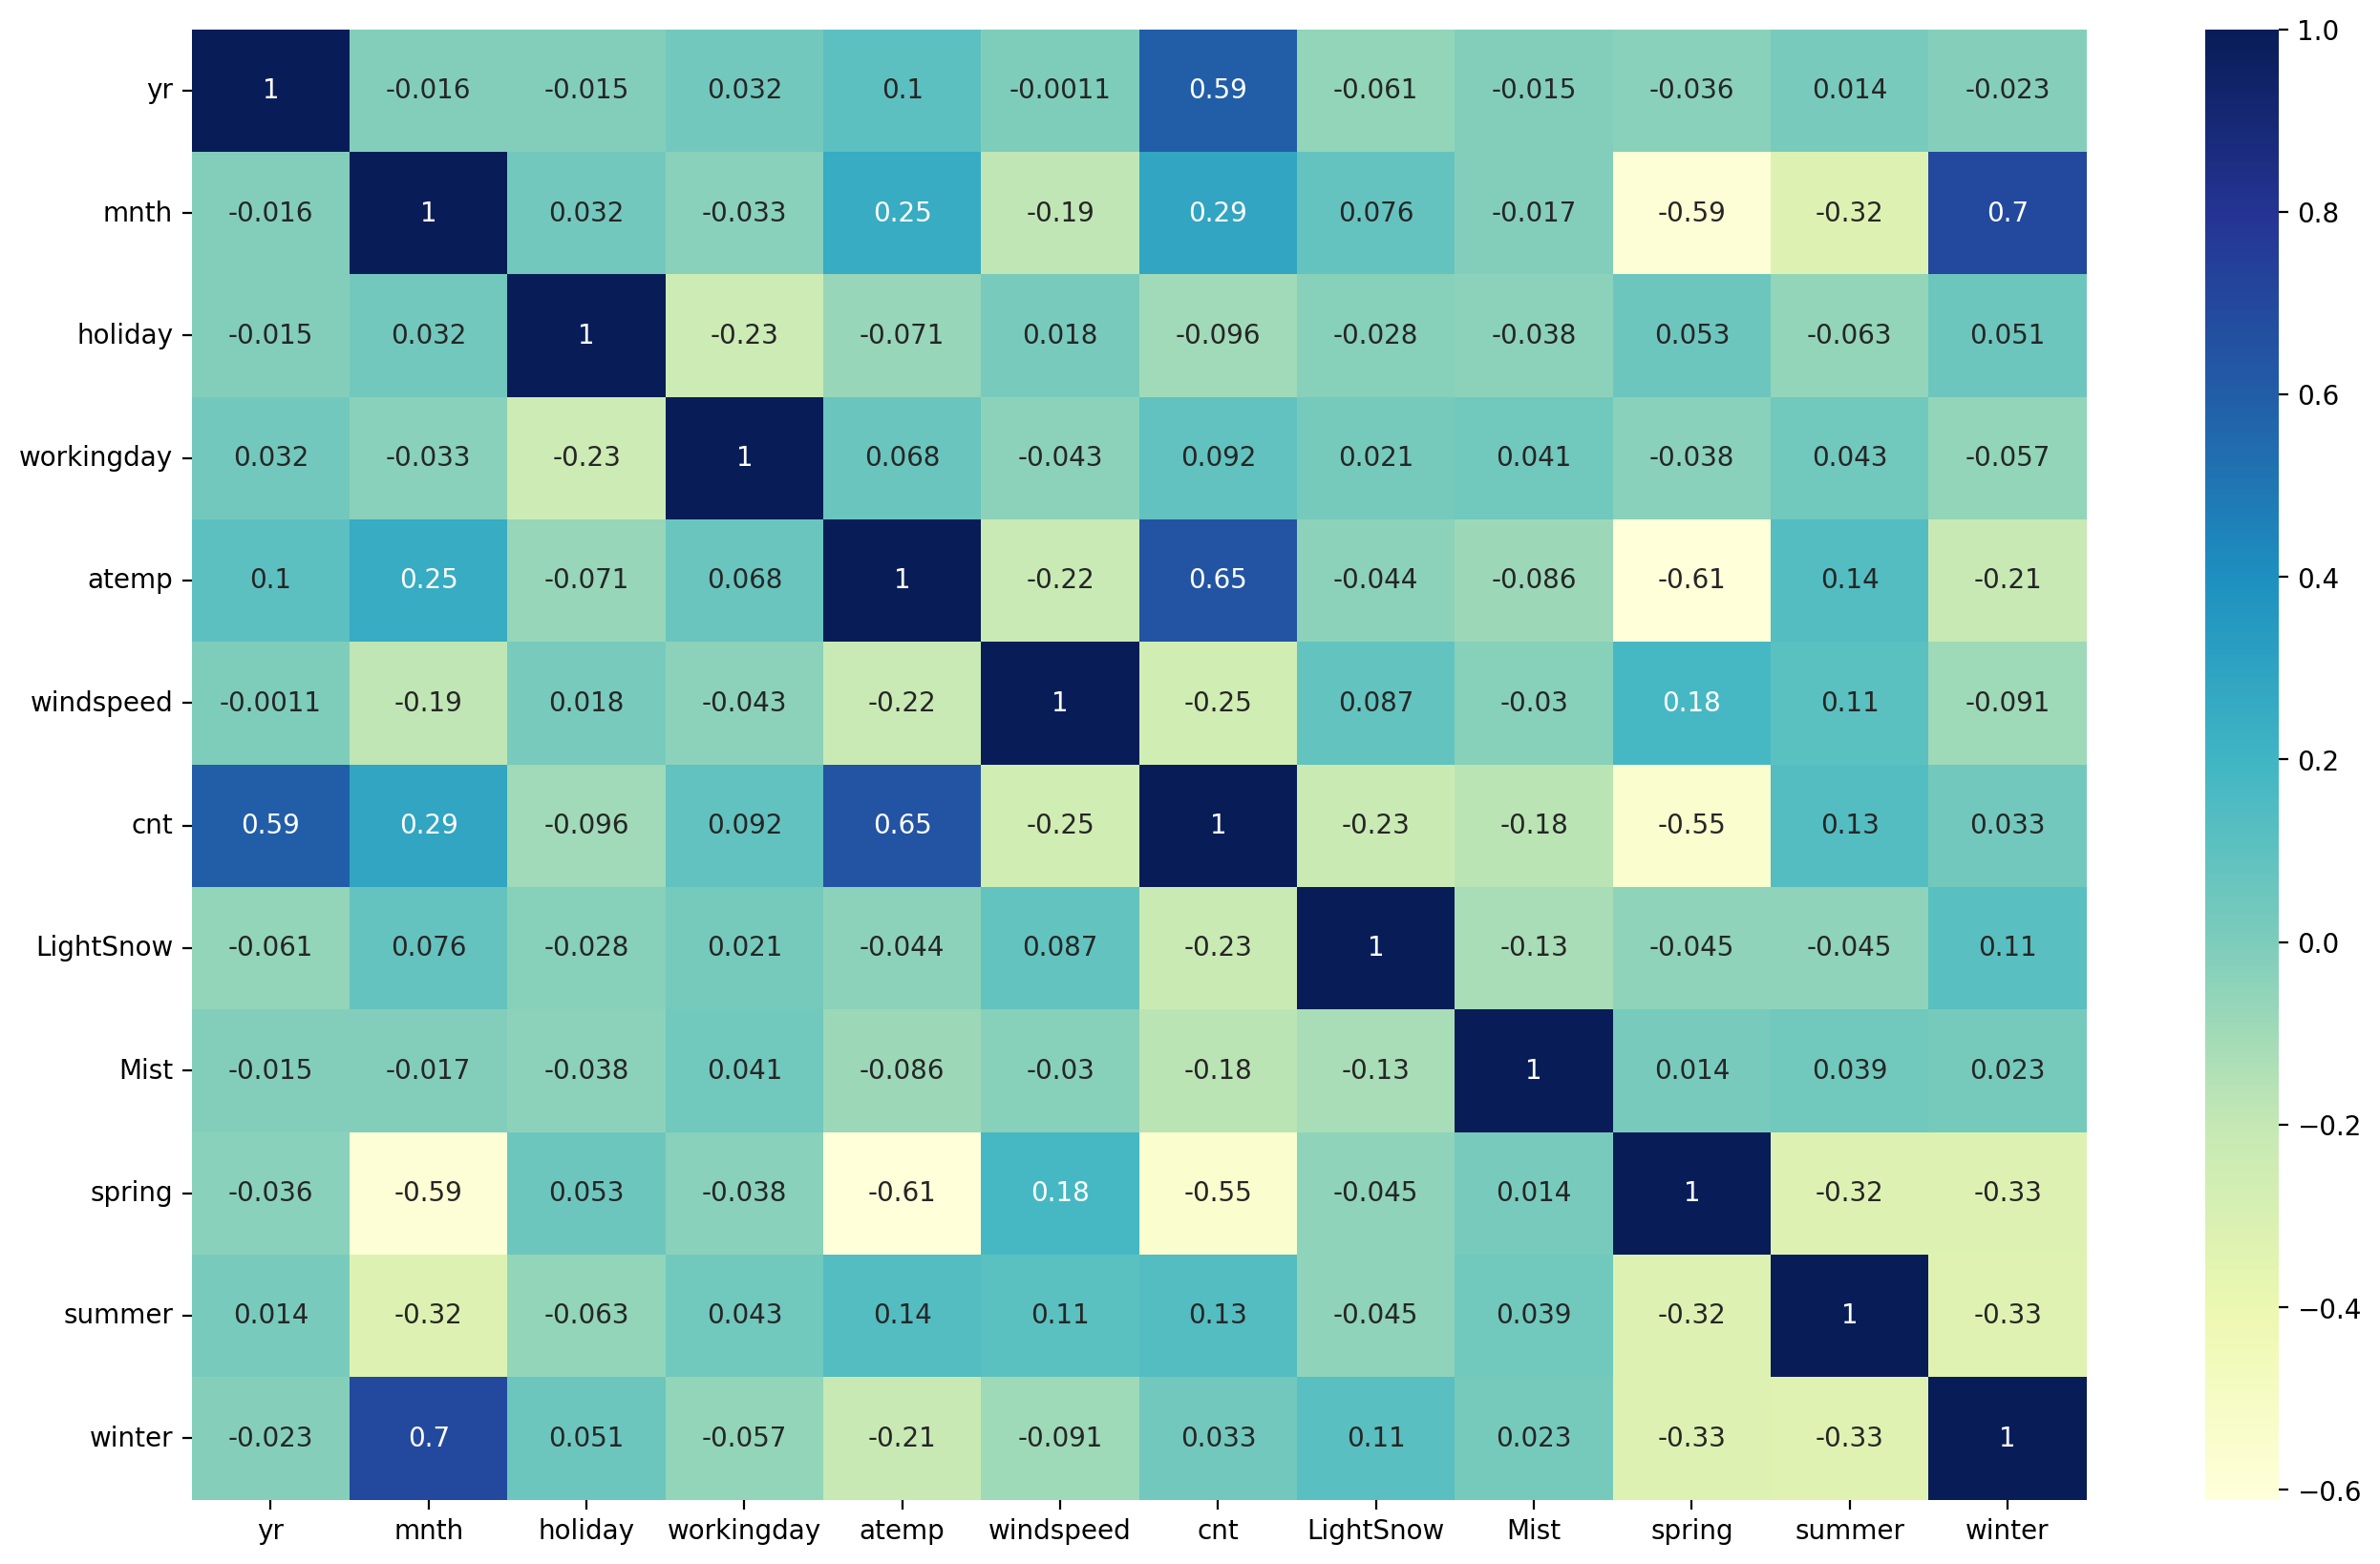

In [90]:
# To check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(data_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

Above co\-relation graph shows 'atemp' is highly correlated with 'cnt', lets see pairplot for 'atemp' vs 'cnt'


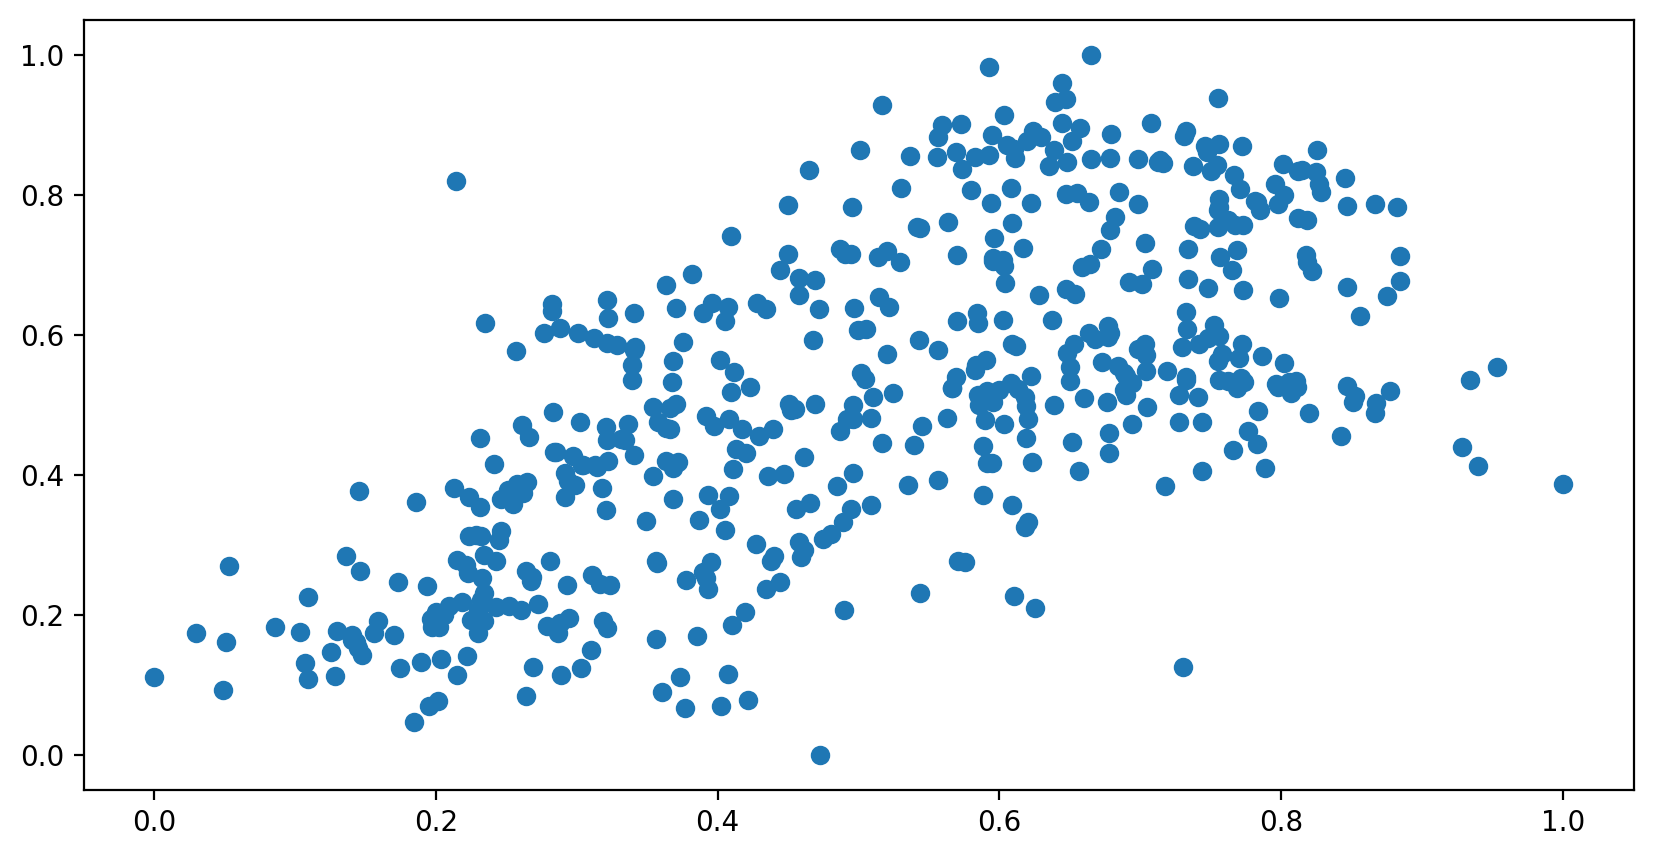

In [91]:
plt.figure(figsize=[10,5])
plt.scatter(data_train.atemp,data_train.cnt)
plt.show()

### 6.Building Model



##### Prepare x and Y set for model building



In [92]:
#'atemp' and 'cnt ' are highly related so building model based on that first

y_train=data_train.pop('cnt')
X_train=data_train

In [93]:
import statsmodels.api as sm

# Adding constant
X_train_lm = sm.add_constant(X_train[['atemp']])

# Creating first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

In [94]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.10e-61
Time:                        12:21:13   Log-Likelihood:                 176.51
No. Observations:                 510   AIC:                            -349.0
Df Residuals:                     508   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.020      8.199      0.0

##### R\-squared obtained is 0.418 to improve this lets add one more variable 'yr' which is next best correlated



In [95]:
X_train_lm = X_train[['atemp', 'yr']]

In [96]:
X_train_lm = sm.add_constant(X_train_lm)

lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     579.5
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          1.07e-131
Time:                        12:21:13   Log-Likelihood:                 341.87
No. Observations:                 510   AIC:                            -677.7
Df Residuals:                     507   BIC:                            -665.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.015      4.810      0.0

##### We can see R2\- adjusted improving from 0.417 to 0.694, we still have scope to improve the model, let add another correlated variable 'mnth' to Model



In [97]:
X_train_lm = X_train[['atemp', 'yr','mnth']]

X_train_lm = sm.add_constant(X_train_lm)

lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     431.7
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          4.71e-139
Time:                        12:21:13   Log-Likelihood:                 362.28
No. Observations:                 510   AIC:                            -716.6
Df Residuals:                     506   BIC:                            -699.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0354      0.015      2.288      0.0

##### we have improved Adj.R\-squared again from 0.694 to 0.717



#### Adding all the variables to model

\-building linear model


In [98]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lm).fit()

lr_1.params

const         0.224534
yr            0.235078
mnth          0.010846
holiday      -0.073090
workingday    0.018173
atemp         0.461115
windspeed    -0.135709
LightSnow    -0.277109
Mist         -0.077604
spring       -0.098983
summer        0.025583
winter        0.053652
dtype: float64

In [99]:
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     206.9
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          9.30e-178
Time:                        12:21:14   Log-Likelihood:                 476.48
No. Observations:                 510   AIC:                            -929.0
Df Residuals:                     498   BIC:                            -878.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2245      0.034      6.667      0.0

### we can drop some variable based on insignificant p\-values, lets use VIF info as well to do that



In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a data frame that contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,mnth,11.04
4,atemp,8.71
5,windspeed,4.59
10,winter,3.78
3,workingday,3.16
8,spring,2.16
0,yr,2.06
9,summer,1.97
7,Mist,1.54
2,holiday,1.09


#### Dropping variable and updating model

###### If we observe 'mnth' has high p\-value and VIF value, so lets drop the column rebuild the model



In [101]:
#dropping insignificant variable
X = X_train.drop('mnth', 1,)
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     228.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          6.52e-179
Time:                        12:21:14   Log-Likelihood:                 476.39
No. Observations:                 510   AIC:                            -930.8
Df Residuals:                     499   BIC:                            -884.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2307      0.030      7.654      0.0

##### Calculate VIF for new model



In [102]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,windspeed,4.48
3,atemp,4.44
2,workingday,3.14
7,spring,2.08
0,yr,2.06
8,summer,1.83
9,winter,1.68
6,Mist,1.53
1,holiday,1.09
5,LightSnow,1.08


#### Dropping the variable and updating the model

if we observe 'summer' has high p\-value of 0.099, so we should drop this variable and rebuild the model


In [103]:
#dropping insignificant variable
X = X.drop('summer', 1,)
X_train_lm = sm.add_constant(X)

#build third fitted model
lr_3 = sm.OLS(y_train, X_train_lm).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     252.1
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          1.55e-179
Time:                        12:21:15   Log-Likelihood:                 475.00
No. Observations:                 510   AIC:                            -930.0
Df Residuals:                     500   BIC:                            -887.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2570      0.026     10.026      0.0

In [104]:
# Calculate the VIFs again for the 3rd fitted model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,atemp,4.43
4,windspeed,3.87
2,workingday,3.08
0,yr,2.05
7,spring,1.72
6,Mist,1.51
8,winter,1.39
1,holiday,1.09
5,LightSnow,1.08


#### Dropping the variable and updating the model

if we observe 'workingday' has high p\-value of 0.54, so we should drop this variable and rebuild the model



In [105]:
#dropping insignificant variable
X.drop(['workingday'],axis=1, inplace=True)
X_train_lm = sm.add_constant(X)

#build fourth fitted model
lr_4 = sm.OLS(y_train, X_train_lm).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     281.7
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          5.66e-180
Time:                        12:21:15   Log-Likelihood:                 473.11
No. Observations:                 510   AIC:                            -928.2
Df Residuals:                     501   BIC:                            -890.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2696      0.025     10.857      0.0

In [106]:
#calculate VIF for fourth fitted model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,windspeed,3.83
2,atemp,3.48
0,yr,2.05
6,spring,1.63
5,Mist,1.49
7,winter,1.37
4,LightSnow,1.08
1,holiday,1.04


##### Now P\-values and VIF values are in acceptable range, now we can use this\(fourth\) model for prediction



### 7.Residual Analysis of train data



Text(0.5, 0, 'Errors')

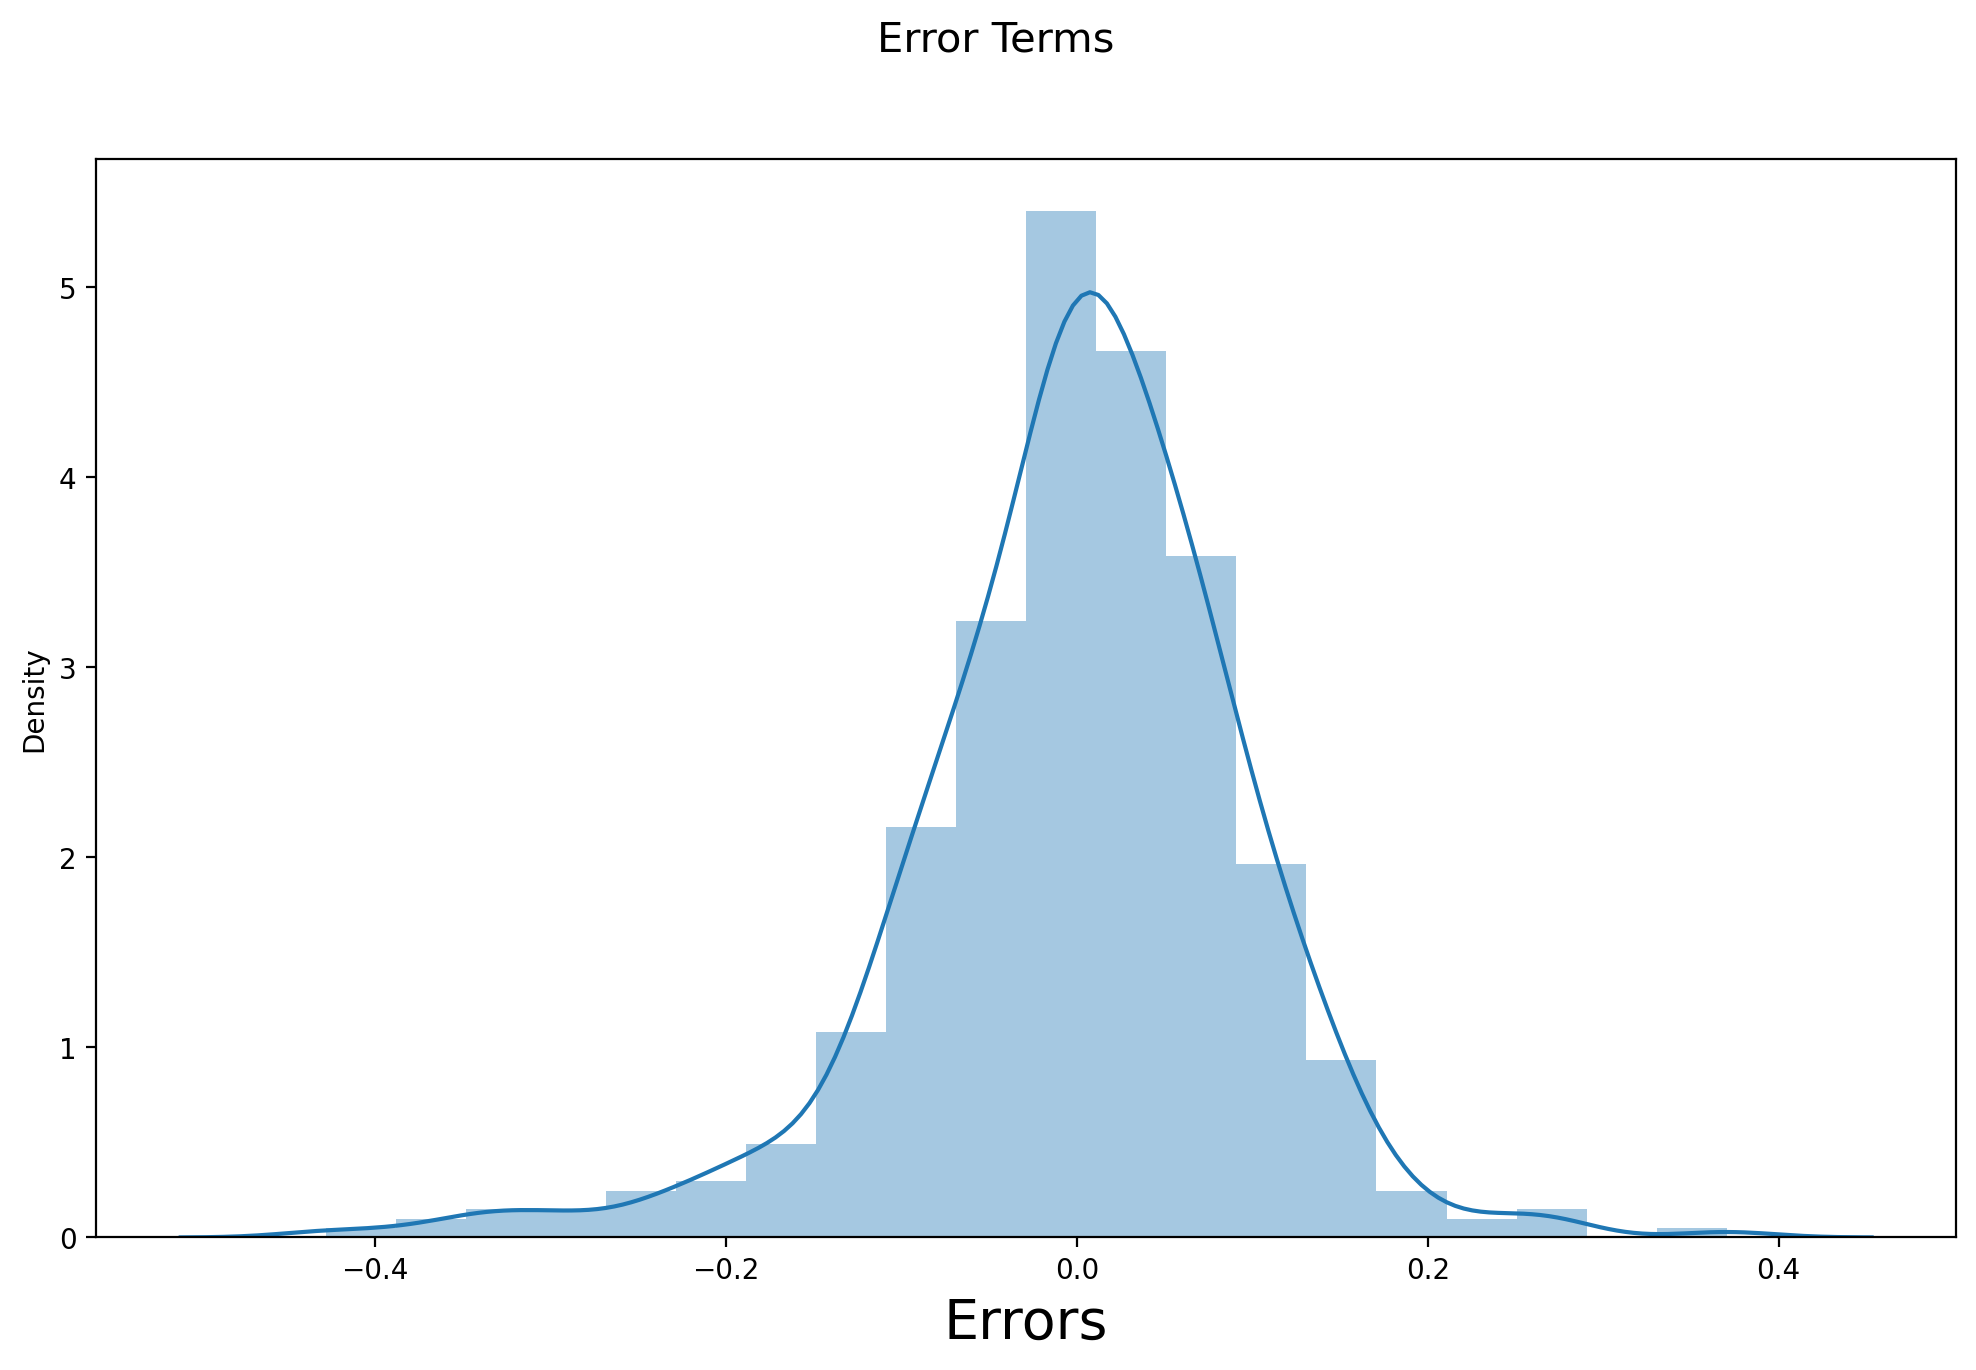

In [107]:
#checking if the error terms are normally distributed by histogram using final model

y_train_cnt = lr_4.predict(X_train_lm)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
#plot heading
fig.suptitle('Error Terms', fontsize = 15)  
#label or x axis
plt.xlabel('Errors', fontsize = 20)          

## 8.Predictions Using the Final Model



#### Applying scaling on test set



In [108]:
data_test[scaler_columns]=scaler.transform(data_test[scaler_columns])
data_test.describe()

,yr,mnth,holiday,workingday,atemp,windspeed,cnt,LightSnow,Mist,spring,summer,winter
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.497717,0.036530,0.698630,0.532991,0.313350,0.520592,0.027397,0.319635,0.255708,0.264840,0.232877
std,0.500722,0.311080,0.188034,0.459904,0.217888,0.159947,0.218435,0.163612,0.467403,0.437258,0.442259,0.423633
min,0.000000,0.000000,0.000000,0.000000,0.025950,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.272727,0.000000,0.000000,0.344751,0.198517,0.377531,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.454545,0.000000,1.000000,0.549198,0.299459,0.524275,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.727273,0.000000,1.000000,0.714132,0.403048,0.672745,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.980934,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing test data into X\_test and y\_test



In [109]:
y_test = data_test.pop('cnt')
X_test = data_test

In [110]:
#adding constant to test data
X_test_c =sm.add_constant(X_test)

In [111]:
#dropping the columns which are dropped in train set
X_test_c = X_test_c.drop(['mnth','workingday', 'summer'],axis=1)
X_test_c.columns

Index(['const', 'yr', 'holiday', 'atemp', 'windspeed', 'LightSnow', 'Mist',
       'spring', 'winter'],
      dtype='object')

In [112]:
# Making predictions using the fourth model

y_pred_m4 = lr_4.predict(X_test_c)

## 9.Model Evaluation



#### Let's calculate R2\-squared score



In [113]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_m4)

0.8018422663305307

Lets plot Actual versus Predicted values



Text(0, 0.5, 'y_pred')

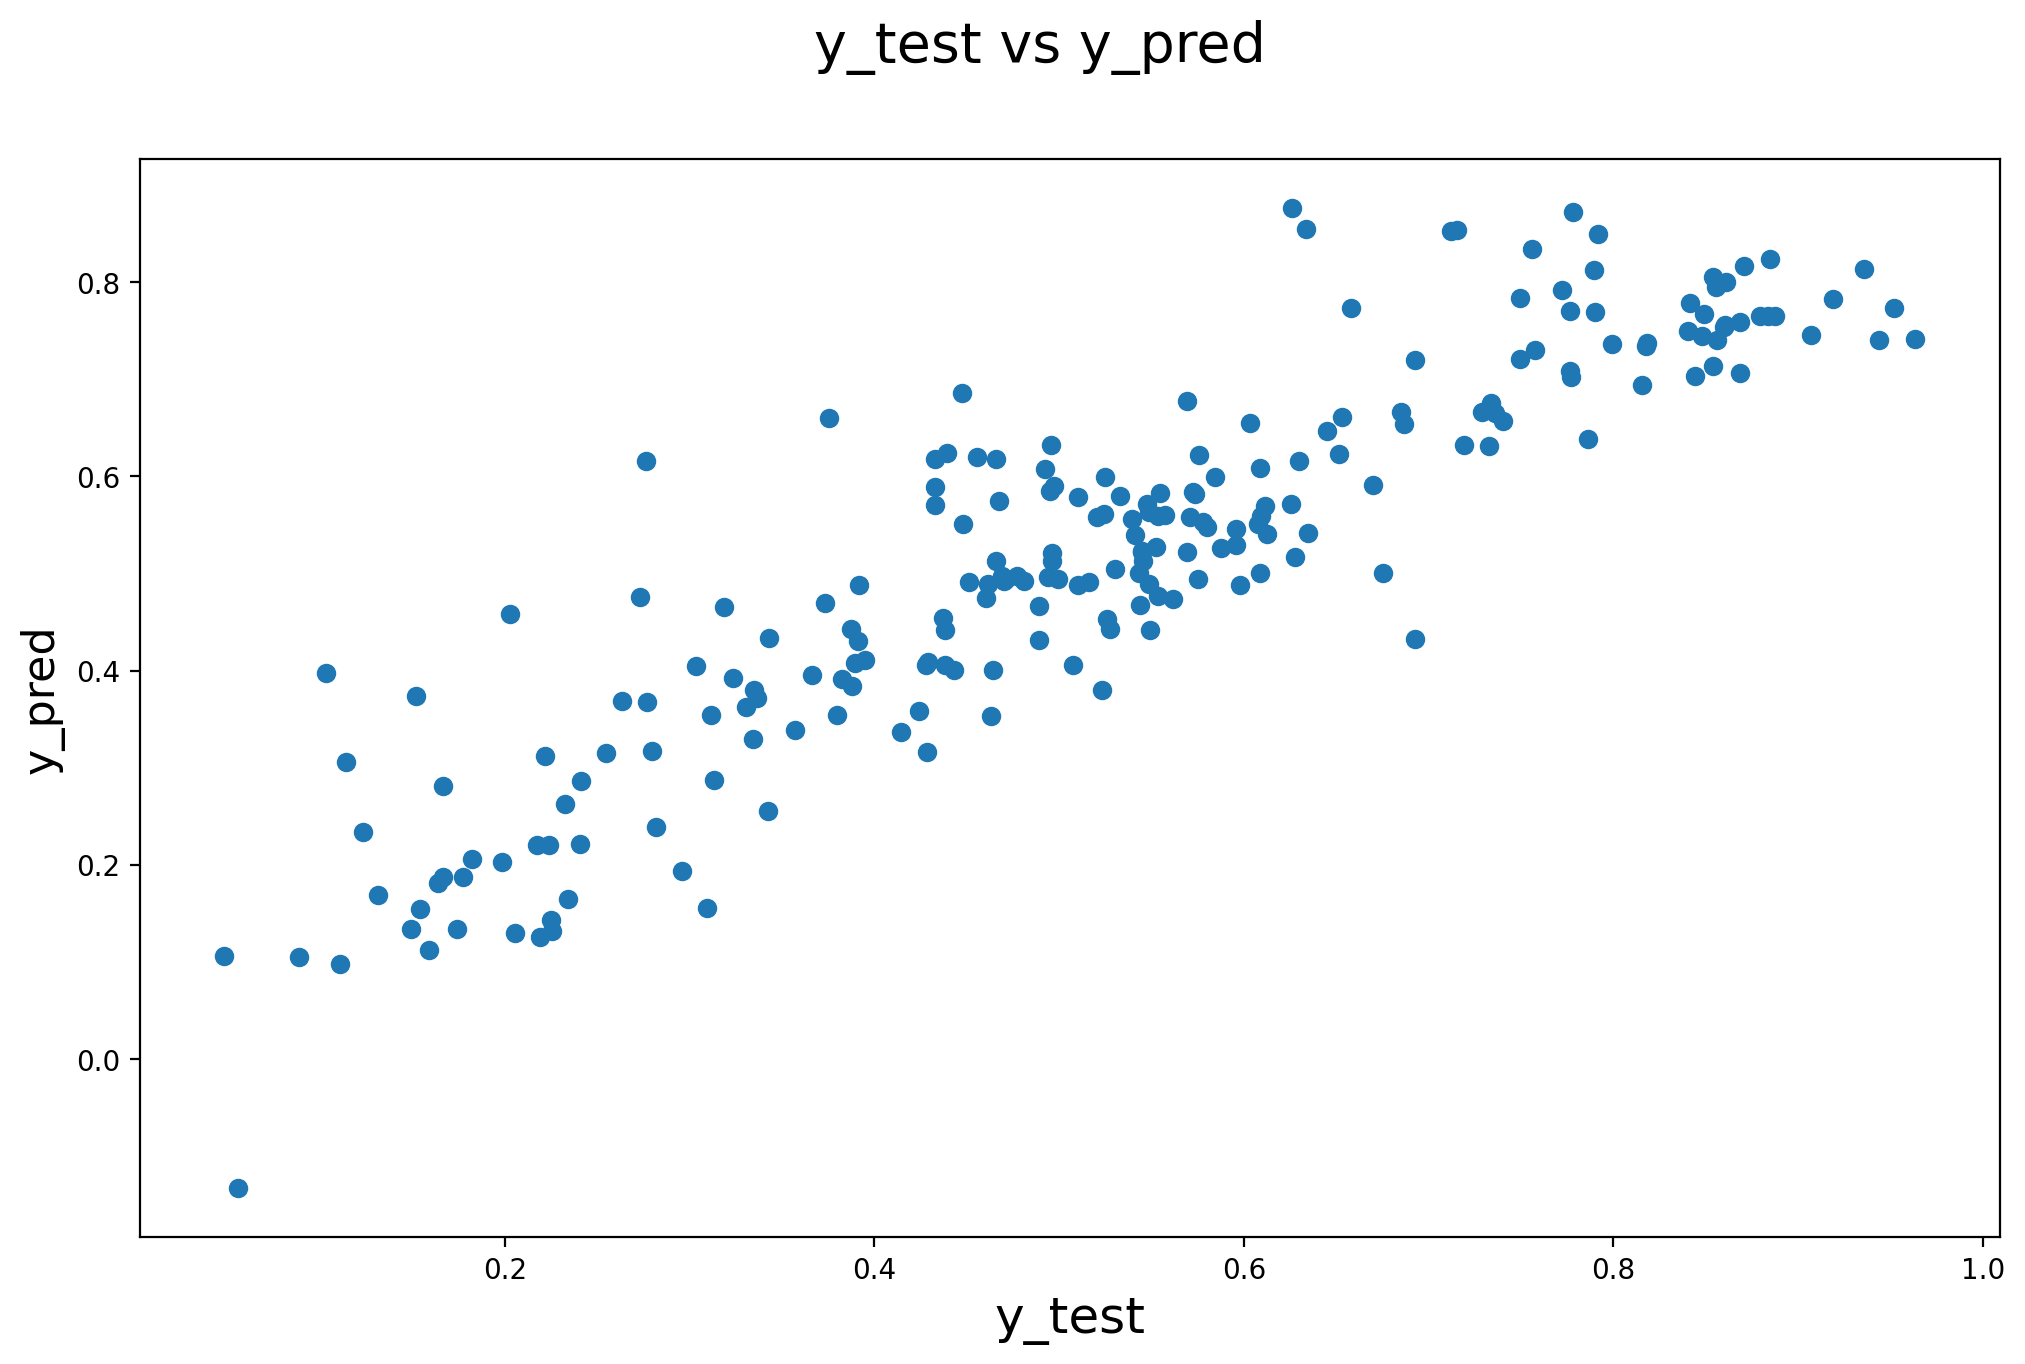

In [57]:
fig = plt.figure()
plt.scatter(y_test, y_pred_m4)
#Plot heading
fig.suptitle('y_test vs y_pred', fontsize = 20)
#Y-label
plt.xlabel('y_test', fontsize = 18)
#X-label
plt.ylabel('y_pred', fontsize = 16)

Equation of our best fitted line is

cnt = 0.236  x yr \- 0.086 x holiday \+ 0.437 x atemp \- 0.132 x windspeed \- 0.278 x LightSnow \- 0.077 x Mist \- 0.125 x spring \+ 0.039 x winter


### Overall we have got good model

80% of the variance of the dependent variable being explained by the variance of the independent variable
